In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if '..' not in sys.path:
    sys.path.append('..')

from data import OneBall2DFreeFallPredictionFromInitialStateWithDiameterDataset

import torch
from torch.utils.data import DataLoader

import reservoirpy as rpy
from reservoirpy.nodes import Input, Reservoir, Ridge, ReLU, ESN
from reservoirpy.observables import mse

from itertools import product
from tqdm.notebook import tqdm_notebook

rpy.verbosity(0)
rpy.set_seed(42)

In [2]:
def calculate_test_loss(model, dataloader, dataset, visualize_first_10_trajectories=True):
    test_loss = (np.sum([mse(model.run(X.squeeze().numpy()), y.squeeze().numpy())*len(y) for X, y in dataloader]) / len(dataset)) ** 0.5
    print('Test loss: ', test_loss)

    if visualize_first_10_trajectories:
        fig1, axs1 = plt.subplots(2, 5, figsize=(20,10))
        fig2, axs2 = plt.subplots(2, 5, figsize=(20,10))

        fig1.suptitle('Y-coordinate over time')
        fig2.suptitle('Trajectory')

        plt.setp(axs1[-1, :], xlabel='Frame number')
        plt.setp(axs1[:, 0], ylabel='Y-coordinate')

        plt.setp(axs2[-1, :], xlabel='X-coordinate')
        plt.setp(axs2[:, 0], ylabel='Y-coordinate')

        for row_id in range(len(axs1)):
            for col_id in range(len(axs1[row_id])):
                # axs1 and axs2 are time series, so only limiting y-axis
                axs1[row_id, col_id].set_ylim(0, 1)

                # axs3 shows trajectories, so limiting both axis
                axs2[row_id, col_id].set_xlim(0, 1)
                axs2[row_id, col_id].set_ylim(0, 1)


        for X, y in dataloader:
            pred = model.run(X.squeeze().numpy())

            for count in range(10):
                gr = np.insert(y.squeeze().numpy()[count].reshape(1,-1)[0], 0, X.squeeze().numpy()[count][0:2])
                pr = np.insert(pred.squeeze()[count].reshape(1,-1)[0], 0, X.squeeze().numpy()[count][0:2])

                axs1[int(count >= 5)][count % 5].plot(gr[1::2], label=f'Ground truth')
                axs1[int(count >= 5)][count % 5].plot(pr[1::2], label='Predicted')
                axs1[int(count >= 5)][count % 5].legend()

                axs2[int(count >= 5)][count % 5].plot(gr[0::2], gr[1::2], label=f'Ground truth')
                axs2[int(count >= 5)][count % 5].plot(pr[0::2], pr[1::2], label='Predicted')
                axs2[int(count >= 5)][count % 5].legend()

            break

        plt.show()
    return test_loss

In [3]:
batch_size = 32

train_data, test_data = OneBall2DFreeFallPredictionFromInitialStateWithDiameterDataset.train_test_split('../data/raw/single-ball-2d-free-fall-initial-with-diameter', test_frac=0.2)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

Test size:  10562
train_test_split response: test fraction rounded to 0.19998485250123074 (10562 simulations)


In [4]:
# Parameters for cross-validation hyperparameter turning

n_units = [50, 70, 100, 150, 300]
lrs = [0.3, 0.5, 0.7]
srs = [0.95, 0.99, 0.998]
ridges = [1e-5, 1e-4, 1e-3, 1e-2]

In [5]:
# dictionary to store the results

import pickle

results = {}

try:
    with open('results_dict_2d.pkl', 'rb') as f:
        results = pickle.load(f)
except:
    results = {}

# Simple ESN

In [6]:
if results == {}:

    # Performing cross-validation hypterparameter turning

    results['simple_esn'] = []

    for units, lr, sr, ridge in product(n_units, lrs, srs, ridges):
        print(f'Testing units={units} \t lr={lr} \t sr={sr} \t ridge={ridge}')

        rpy.set_seed(42)

        reservoir1 = Reservoir(units=units, lr=lr, sr=sr, input_bias=False)
        readout1 = Ridge(output_dim=48, ridge=ridge) >> ReLU()

        model1 = reservoir1 >> readout1

        for X, y in train_dataloader:
            model1.fit(X.squeeze().numpy(), y.squeeze().numpy())

        test_loss = calculate_test_loss(model1, test_dataloader, test_data, visualize_first_10_trajectories=False)

        results['simple_esn'].append(
            {
                'units': units,
                'lr': lr,
                'sr': sr,
                'ridge': ridge,
                'test_loss': test_loss
            }
        )

        print()

        with open('results_dict_2d.pkl', 'wb') as f:
            pickle.dump(results, f)

  0%|          | 0/1352 [00:00<?, ?it/s]

Test loss:  0.05893520618406058


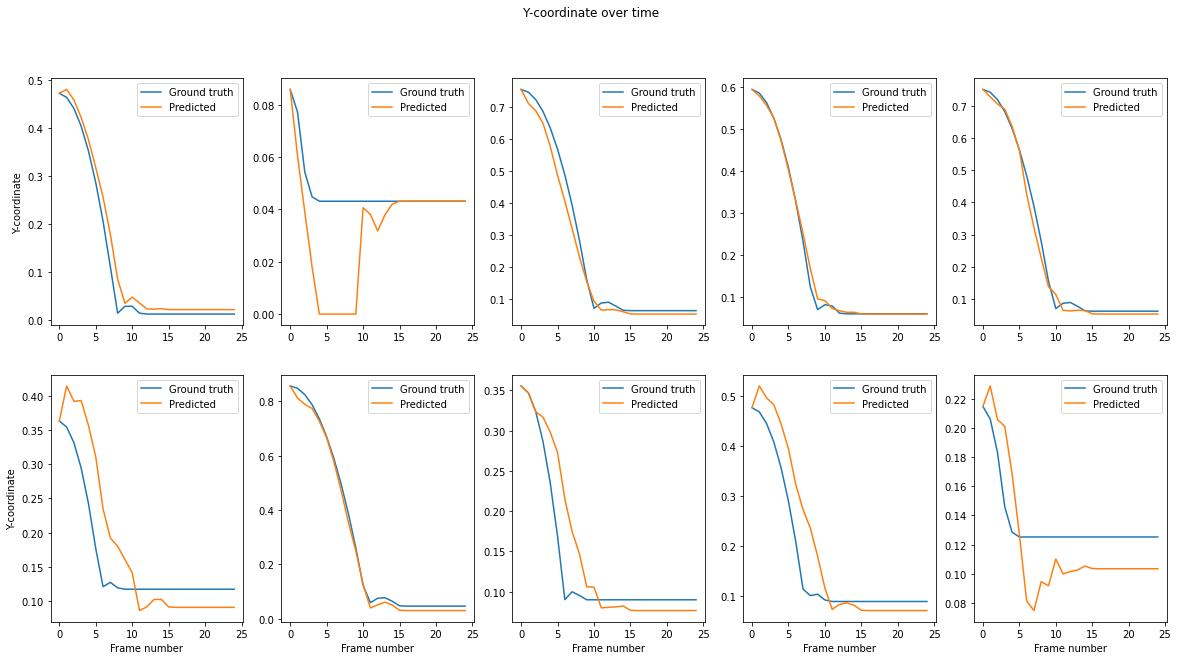

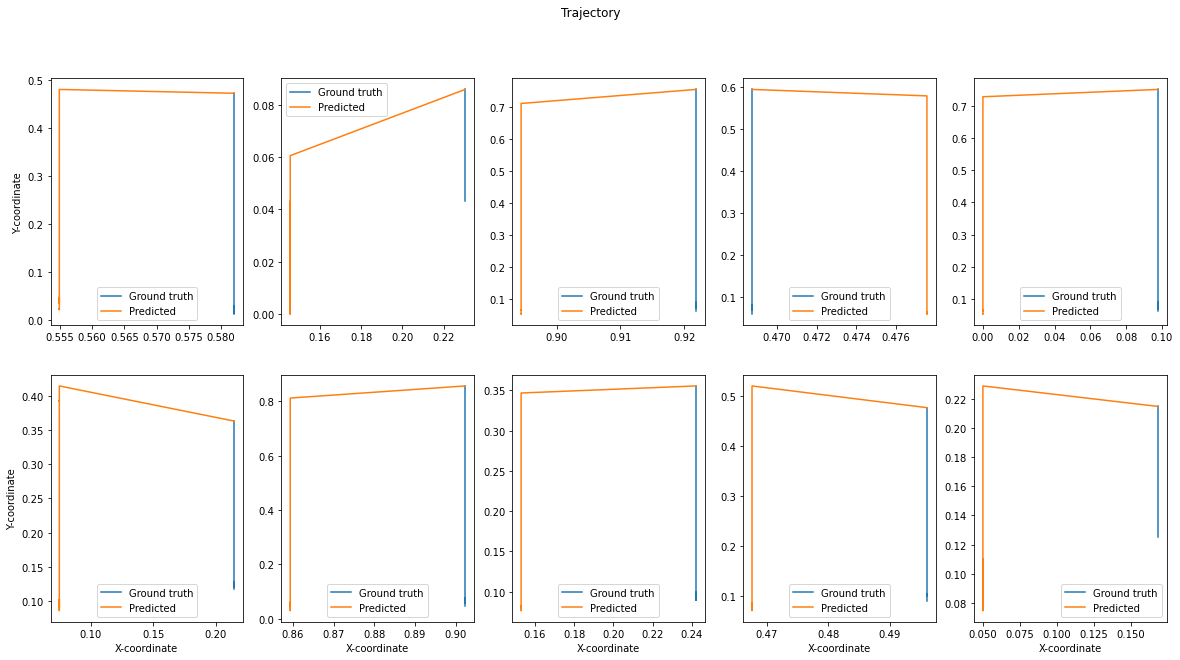

In [7]:
best_result = min(results['simple_esn'], key=lambda x: x['test_loss'])

rpy.set_seed(42)

reservoir1 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
readout1 = Ridge(output_dim=48, ridge=best_result['ridge']) >> ReLU()

model1 = reservoir1 >> readout1

for X, y in tqdm_notebook(train_dataloader):
    model1.fit(X.squeeze().numpy(), y.squeeze().numpy())


test_loss = calculate_test_loss(model1, test_dataloader, test_data, visualize_first_10_trajectories=True)

In [8]:
best_result

{'units': 70,
 'lr': 0.7,
 'sr': 0.95,
 'ridge': 0.01,
 'test_loss': 0.0628183330289296}

# Deep ESN

## 2 sequential

Test loss:  0.04798785965962337


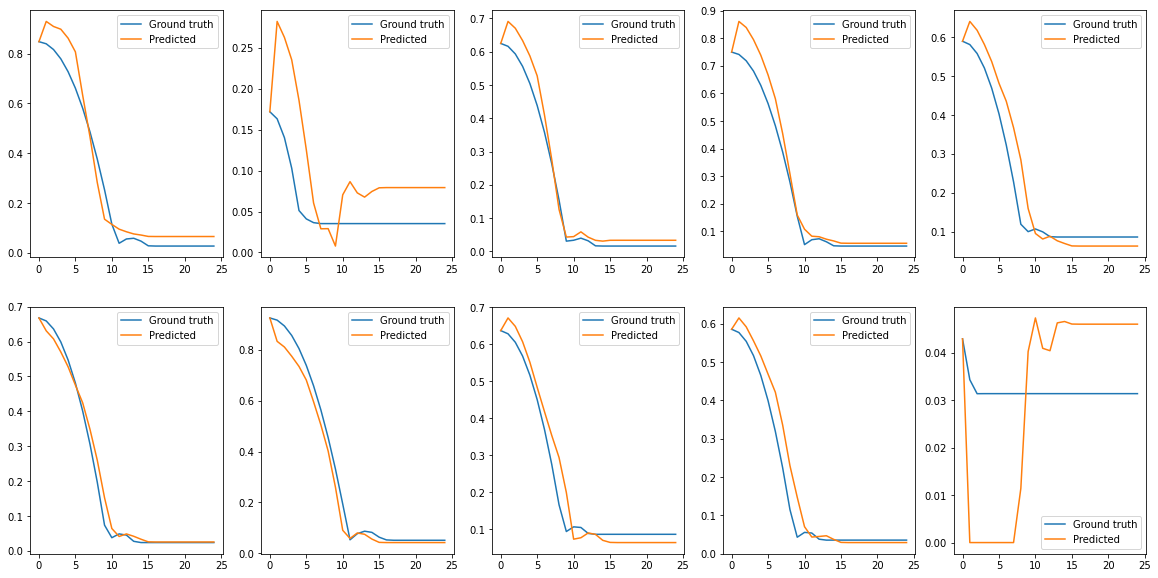

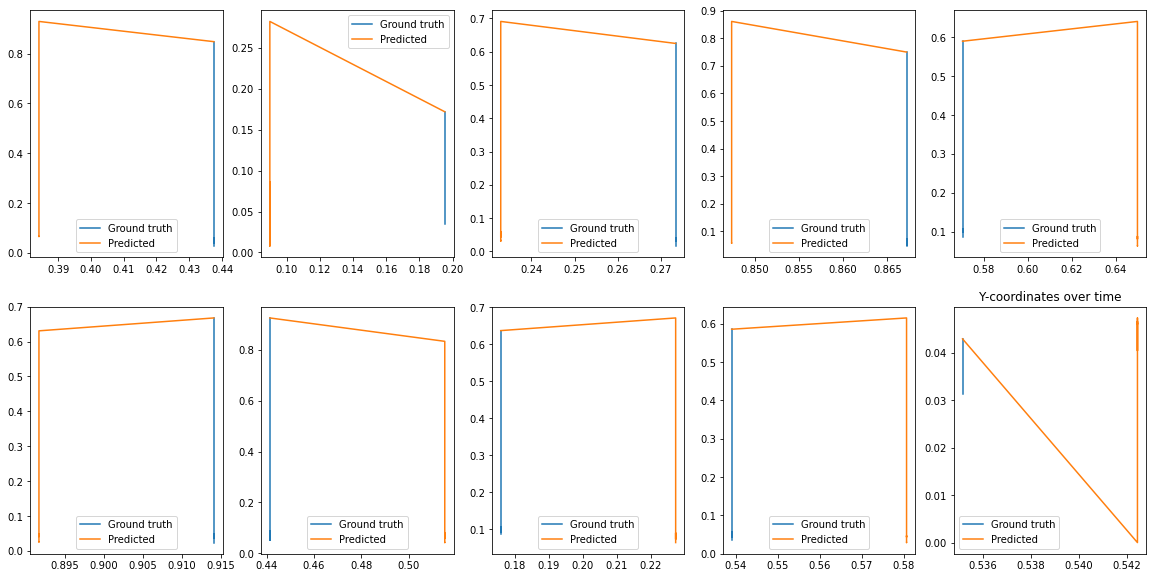

In [8]:
rpy.set_seed(42)

reservoir1 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
readout1 = Ridge(output_dim=48, ridge=best_result['ridge'], name='2-seq-1')
reservoir2 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
readout2 = Ridge(output_dim=48, ridge=best_result['ridge'], name='2-seq-2') >> ReLU()

model2 = reservoir1 >> readout1 >> reservoir2 >> readout2

for X, y in train_dataloader:
    model2.fit(X.squeeze().numpy(), {'2-seq-1': y.squeeze().numpy(), '2-seq-2': y.squeeze().numpy()})

test_loss = calculate_test_loss(model2, test_dataloader, test_data, visualize_first_10_trajectories=True)

## 2 parallel

Test loss:  0.060432086467457326


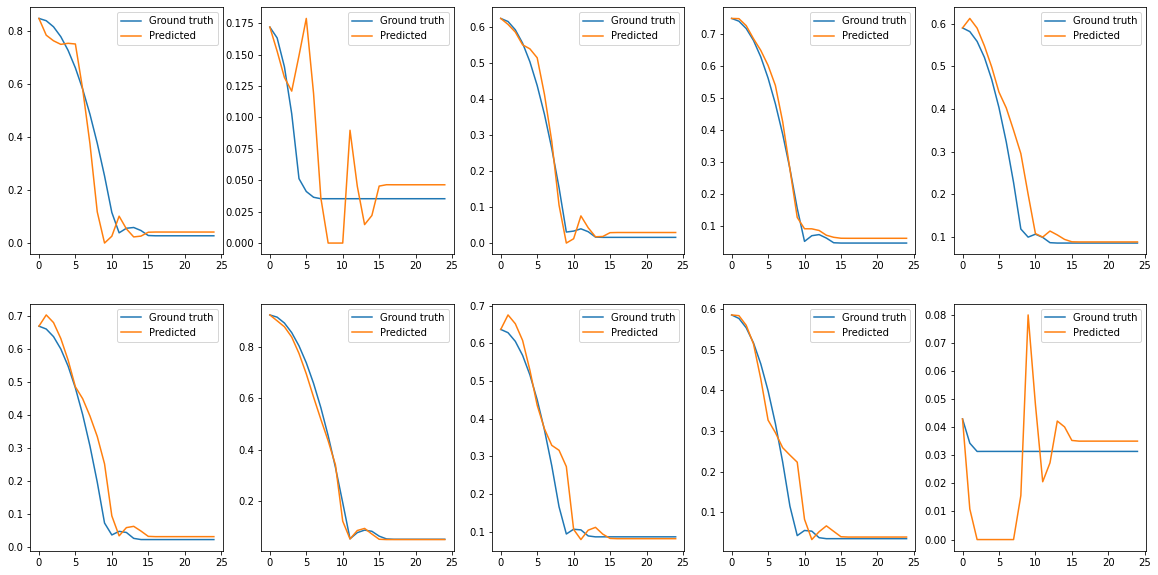

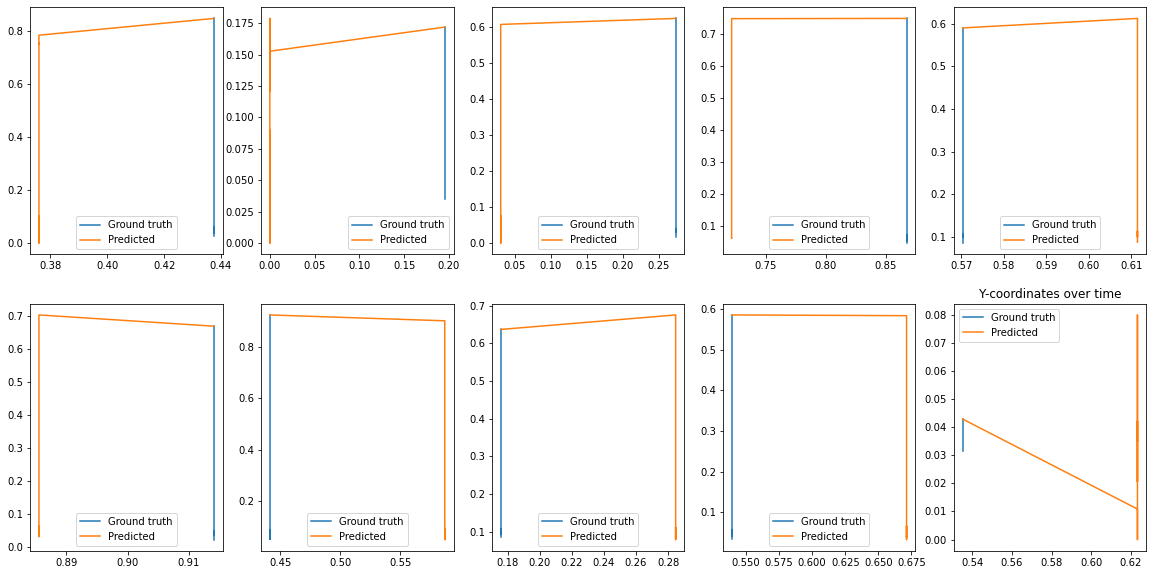

In [10]:
rpy.set_seed(42)

reservoir1 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
reservoir2 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
readout = Ridge(output_dim=48, ridge=best_result['ridge']) >> ReLU()

model3 = [reservoir1, reservoir2] >> readout & reservoir1 >> reservoir2

for X, y in train_dataloader:
    model3.fit(X.squeeze().numpy(), y.squeeze().numpy())

test_loss = calculate_test_loss(model3, test_dataloader, test_data, visualize_first_10_trajectories=True)